<a href="https://colab.research.google.com/github/natanrajch/DiploDatos/blob/main/MELI/Hito_5_Grupo_B_MentoMELI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hito 5 - Grupo B - MELI Data Challenge 2020 - DiploDatos 2021
Análisis No supervisado del dataset

##Dependencies and Datasets

In [30]:
!pip install scikit-learn --upgrade

     |████████████████████████████████| 23.1 MB 4.7 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [1]:
import gzip
import pandas as pd
import urllib
import tarfile
import urllib.request
import numpy as np
import random
import json
import bisect
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import scipy.sparse as sps
import operator

In [2]:
url_item_data = "https://meli-data-challenge.s3.amazonaws.com/2020/item_data.jl.gz"
url_train_data = "https://meli-data-challenge.s3.amazonaws.com/2020/train_dataset.jl.gz"

In [3]:
# PARA TRABAJAR CON UNA SAMPLE DEL TRAIN DATA SET:
# sample = 150000
# def binary_search(items, key, lo=0):
#     idx = bisect.bisect_left(items, key, lo)
#     if items[idx] != key:
#          return -1

#     return idx
# sample_list = random.sample(list(range(420000)),sample)
# sample_list.sort()
# ind = 0
# train_data = []
# with urllib.request.urlopen(url_train_data) as handle:
#   gz = gzip.GzipFile(fileobj=handle)
#   for i, line in enumerate(gz):
#     binary = binary_search(sample_list,i,ind)
#     if binary != -1:
#       train_data.append(json.loads(line.strip().decode('utf-8')))
#       ind = binary
train_data = []
with urllib.request.urlopen(url_train_data) as handle:
  gz = gzip.GzipFile(fileobj=handle)
  for i, line in enumerate(gz):
    train_data.append(json.loads(line.strip().decode('utf-8')))

In [4]:
train_df = pd.DataFrame(train_data)
train_df.head()

,user_history,item_bought
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737
2,"[{'event_info': 248595, 'event_timestamp': '20...",1909110
3,"[{'event_info': 'RADIOBOSS', 'event_timestamp'...",1197370
4,"[{'event_info': 'AMAZFIT BIP', 'event_timestam...",2049207


In [5]:
item_data = []
with urllib.request.urlopen(url_item_data) as handle:
  gz = gzip.GzipFile(fileobj=handle)
  for i, line in enumerate(gz):
    item_data.append(json.loads(line.strip().decode('utf-8')))

In [6]:
item_df = pd.DataFrame(item_data)
del train_data
del item_data
del gz

In [7]:
item_df.head(2)

,item_id,title,domain_id,product_id,price,category_id,condition
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,None,1150000.00,MLM170527,new
1,871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800,1392.83,MLM151595,new


In [8]:
item_list = item_df['item_id'].tolist()
domain_list = item_df['domain_id'].tolist()
item_domain_dict = dict(zip(item_list, domain_list))

##Armado de Features

### El item comprado fue visto con anterioridad?

In [9]:
train_df['bought_was_viewed'] = train_df.apply(lambda row: row['item_bought'] in [history['event_info'] for history in row['user_history']], axis=1)

### Cant. Views y Searchs por compra?

In [10]:
def count_event_type(list_of_events, type_of_event):
  count = 0
  for event in list_of_events:
    if event['event_type'] == type_of_event:
      count += 1
  return count

train_df['view_count'] = train_df.apply(lambda row: count_event_type(row['user_history'],'view'), axis = 1)
train_df['search_count'] = train_df.apply(lambda row: count_event_type(row['user_history'],'search'), axis = 1)


In [11]:
train_df['event_count'] = train_df.view_count + train_df.search_count

In [12]:
def count_bought_views(list_of_events, item_bought):
  count = 0
  for event in list_of_events:
    if event['event_type'] == 'view':
      if event['event_info'] == item_bought:
        count += 1
  return count

train_df['bought_view_count'] = train_df.apply(lambda row: count_bought_views(row['user_history'],row['item_bought']), axis = 1)

### Análisis de la condición de item dentro de cada búsqueda

In [13]:
item_list = item_df['item_id'].tolist()
condition_list = item_df['condition'].tolist()
item_condition_dict = dict(zip(item_list, condition_list))

def find_condition(list_of_events, type_of_event, condition):
  count = 0
  for event in list_of_events:
    if event['event_type'] == type_of_event:
      condition_item = item_condition_dict[event['event_info']]
      if condition_item == condition:
        count += 1
  return count

train_df['new_count'] = train_df.apply(lambda row: find_condition(row['user_history'],'view', 'new'), axis = 1)
train_df['use_count'] = train_df.apply(lambda row: find_condition(row['user_history'],'view', 'used'), axis = 1)
train_df['not_specified_count'] = train_df.apply(lambda row: find_condition(row['user_history'],'view', 'not_specified'), axis = 1)

### Procedencia de la compra: BRASIL (MLB) o MEXICO (MLM)

In [14]:
train_df['is_brazil'] = train_df.apply(lambda row: item_domain_dict[row.item_bought][:3] == 'MLB' if item_domain_dict[row.item_bought] else 1, axis=1)

###Promedio de precio de los items vistos

In [15]:
item_list = item_df['item_id'].tolist()
price_list = item_df['price'].astype(float).tolist()
item_price_dict = dict(zip(item_list, price_list))

def find_mean_price_of_viewed(row):
  prices=[]
  for event in row.user_history:
        if event['event_type'] == 'view':
          prices.append(item_price_dict[event['event_info']])
  if prices:
    return sum(prices) / len(prices) #PROMEDIO de prices
  else:
    return np.nan

train_df['viewed_prices_mean'] = train_df.apply(find_mean_price_of_viewed, axis=1)

###El domain de la compra estuvo entre los items vistos? 
Cierto para aprox el 50% de los casos (203857 sobre 413163)

In [16]:
train_df['domain_was_viewed'] = train_df.apply(lambda row: item_domain_dict[row.item_bought] in [item_domain_dict[history['event_info']] for history in row['user_history'] if history['event_type'] == 'view'], axis=1)

###Cuántas veces aparece el domain de la compra?

In [17]:
def contar_domain(row):
  count = 0
  bdom = item_domain_dict[row.item_bought]
  if row.domain_was_viewed == False:
    return 0
  else:
    for history in row['user_history']:
      if history['event_type'] == 'view':
        if item_domain_dict[history['event_info']] == bdom:
          count += 1
    return count

train_df['bdom_views'] = train_df.apply(contar_domain, axis=1)


### Cant. domains únicos vistos

In [18]:
train_df['unique_domains_viewed'] = train_df.apply(lambda row: len(set([item_domain_dict[history['event_info']] for history in row['user_history'] if history['event_type'] == 'view'])), axis=1)


### Cant. items únicos vistos

In [19]:
train_df['unique_items_viewed'] = train_df.apply(lambda row: len(set([history['event_info'] for history in row['user_history'] if history['event_type'] == 'view'])), axis=1)

In [20]:
train_df.head(3)

,user_history,item_bought,bought_was_viewed,view_count,search_count,event_count,bought_view_count,new_count,use_count,not_specified_count,is_brazil,viewed_prices_mean,domain_was_viewed,bdom_views,unique_domains_viewed,unique_items_viewed
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830,False,18,1,19,0,18,0,0,True,84.185556,True,18,1,2
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737,True,8,5,13,3,6,1,1,True,153.337500,True,7,2,6
2,"[{'event_info': 248595, 'event_timestamp': '20...",1909110,False,2,0,2,0,2,0,0,True,139.000000,False,0,1,1


##Clustering:

### Elección de columnas relevantes

In [21]:
relevant_columns = ['bought_was_viewed', 'view_count',
                    'search_count', 'event_count', 'bought_view_count', 'new_count',
                    'use_count', 'not_specified_count', 'is_brazil', 'viewed_prices_mean',
                    'domain_was_viewed', 'bdom_views', 'unique_domains_viewed',
                    'unique_items_viewed']
X = train_df[relevant_columns]


In [22]:
X.fillna(X.viewed_prices_mean.median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


### K-Means

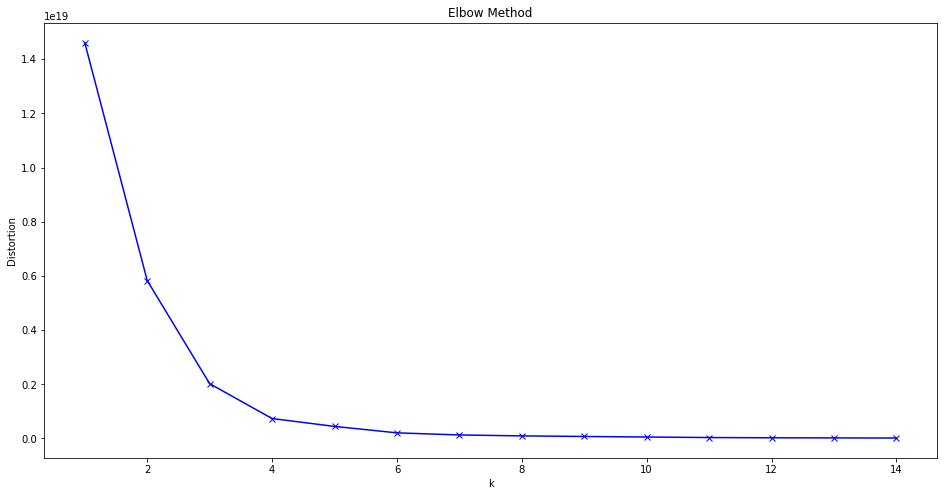

In [23]:
from sklearn.cluster import KMeans,MeanShift
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

Conviene utilizar un K = 4

In [24]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [25]:
len(kmeanModel.labels_), len(X)

(413163, 413163)

In [26]:
clustered_X = X.copy()
clustered_X['kmeans'] = kmeanModel.labels_
clustered_X.groupby('kmeans').describe()

view_count                                  ... unique_items_viewed                        
            count       mean        std  min  25%  ...                 min   25%  50%   75%    max
kmeans                                             ...                                            
0        413130.0  14.352855  19.293453  0.0  2.0  ...                 0.0  2.00  4.0  10.0  229.0
1             6.0   5.833333   4.578937  1.0  3.0  ...                 1.0  2.25  6.0   6.0    8.0
2             1.0   7.000000        NaN  7.0  7.0  ...                 6.0  6.00  6.0   6.0    6.0
3            26.0  14.615385  15.171228  2.0  4.5  ...                 2.0  3.25  6.5  14.0   41.0

[4 rows x 88 columns]

K-means no encuentra clusters útiles, apenas ha separado a 33 usuarios

### Hierarchical

In [40]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=8, linkage='average', compute_distances=True)
agg.fit(X.sample(10000, random_state=4))

AgglomerativeClustering(compute_distances=True, linkage='average', n_clusters=8)

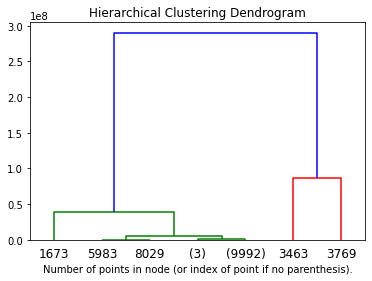

In [41]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [42]:
X_cl = X.sample(10000, random_state=4).copy()
X_cl['agg'] = agg.labels_
X_cl.groupby('agg').describe()

view_count                              ... unique_items_viewed                    
         count       mean        std   min  ...                 25%   50%    75%    max
agg                                         ...                                        
0          2.0  49.500000  24.748737  32.0  ...               29.25  30.5  31.75   33.0
1          2.0  20.000000   0.000000  20.0  ...               15.50  16.0  16.50   17.0
2       9989.0  14.631895  19.745542   0.0  ...                2.00   4.0  10.00  111.0
3          1.0  33.000000        NaN  33.0  ...               16.00  16.0  16.00   16.0
4          1.0  17.000000        NaN  17.0  ...               15.00  15.0  15.00   15.0
5          1.0   3.000000        NaN   3.0  ...                3.00   3.0   3.00    3.0
6          3.0  34.000000  14.177447  18.0  ...               20.00  28.0  33.00   38.0
7          1.0   6.000000        NaN   6.0  ...                4.00   4.0   4.00    4.0

[8 rows x 88 columns]

Tampoco logramos separar clusters mediante este método

### DBSCAN

In [43]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.3, min_samples=10)
db.fit(X)

DBSCAN(eps=0.3, min_samples=10)

In [45]:
from sklearn import metrics
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Estimated number of clusters: 794
Estimated number of noise points: 366679
Silhouette Coefficient: -0.781


TypeError: ignored

##Preguntas aún no respondidas:

### ¿Existen palabras que estén dominando nuestros títulos y no aportan valor semántico?


###Sirve categorizar a los compradores según la cantidad de views o searches que hacen?

### Posibilidades: Eliminar a todos los que no vieron el dominio comprado, y entrenar unicamente con el otro 50%

### Entrenar con los dos grupos de datos por separado. Analizar si entre el 50% que no busco el dominio de la compra, existen patrones en comun: buscan en random? algun otro patron que nos permita identificarlos?

### Chequear variable tiempo... Se puede poner un weight según lejanía de la view/search. Pero esto es peligroso, porque para la mayor parte de los casos, donde tenemos pocos events, es imposible definir si los mismos ocurrieron hace 2 semanas o hace 2 horas.

### Chequear % de vistas del domain de la compra, separado por domain
### Interpretar mediante NLP las searches a un domain (o a un product si se da)
### Agregar una columna con el domain predicho por las searches, o incluso una matriz con domains. Re-analizar distribucion de gente que vio ALGO sobre su producto de compra, teniendo en cuenta las searches (quizás no entraron a  ninguna view, pero sí estuvieron buscando sobre el producto)

In [ ]:
# # !pip install nltk
# import nltk
# nltk.download('all')

In [ ]:
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

In [ ]:
# X ="horror horror horror horror"
# Y ="horror horror horror horror Lights out is ble bli blu asd dfre"
  
# # tokenization
# X_list = word_tokenize(X) 
# Y_list = word_tokenize(Y)
  
# # sw contains the list of stopwords
# sw = stopwords.words('english') 
# l1 =[];l2 =[]
  
# # remove stop words from the string
# X_set = {w for w in X_list if not w in sw} 
# Y_set = {w for w in Y_list if not w in sw}
  
# # form a set containing keywords of both strings 
# rvector = X_set.union(Y_set) 
# for w in rvector:
#     if w in X_set: l1.append(1) # create a vector
#     else: l1.append(0)
#     if w in Y_set: l2.append(1)
#     else: l2.append(0)
# c = 0
  
# # cosine formula 
# for i in range(len(rvector)):
#         c+= l1[i]*l2[i]
# cosine = c / float((sum(l1)*sum(l2))**0.5)
# print("similarity: ", cosine)